数据加载完成: 12119 行
时间范围: 2010-01-04 13:59:00 至 2025-01-24 21:43:00
时长统计: 均值=94.05, 标准差=64.97

提取特征: 序列长度=12119, 窗口大小=15

特征缺失值统计:

成功提取特征: t, derivative_1, derivative_2, rolling_mean, rolling_std, rolling_skew, hurst, curvature, persistence_entropy
可视化最后 200 个样本


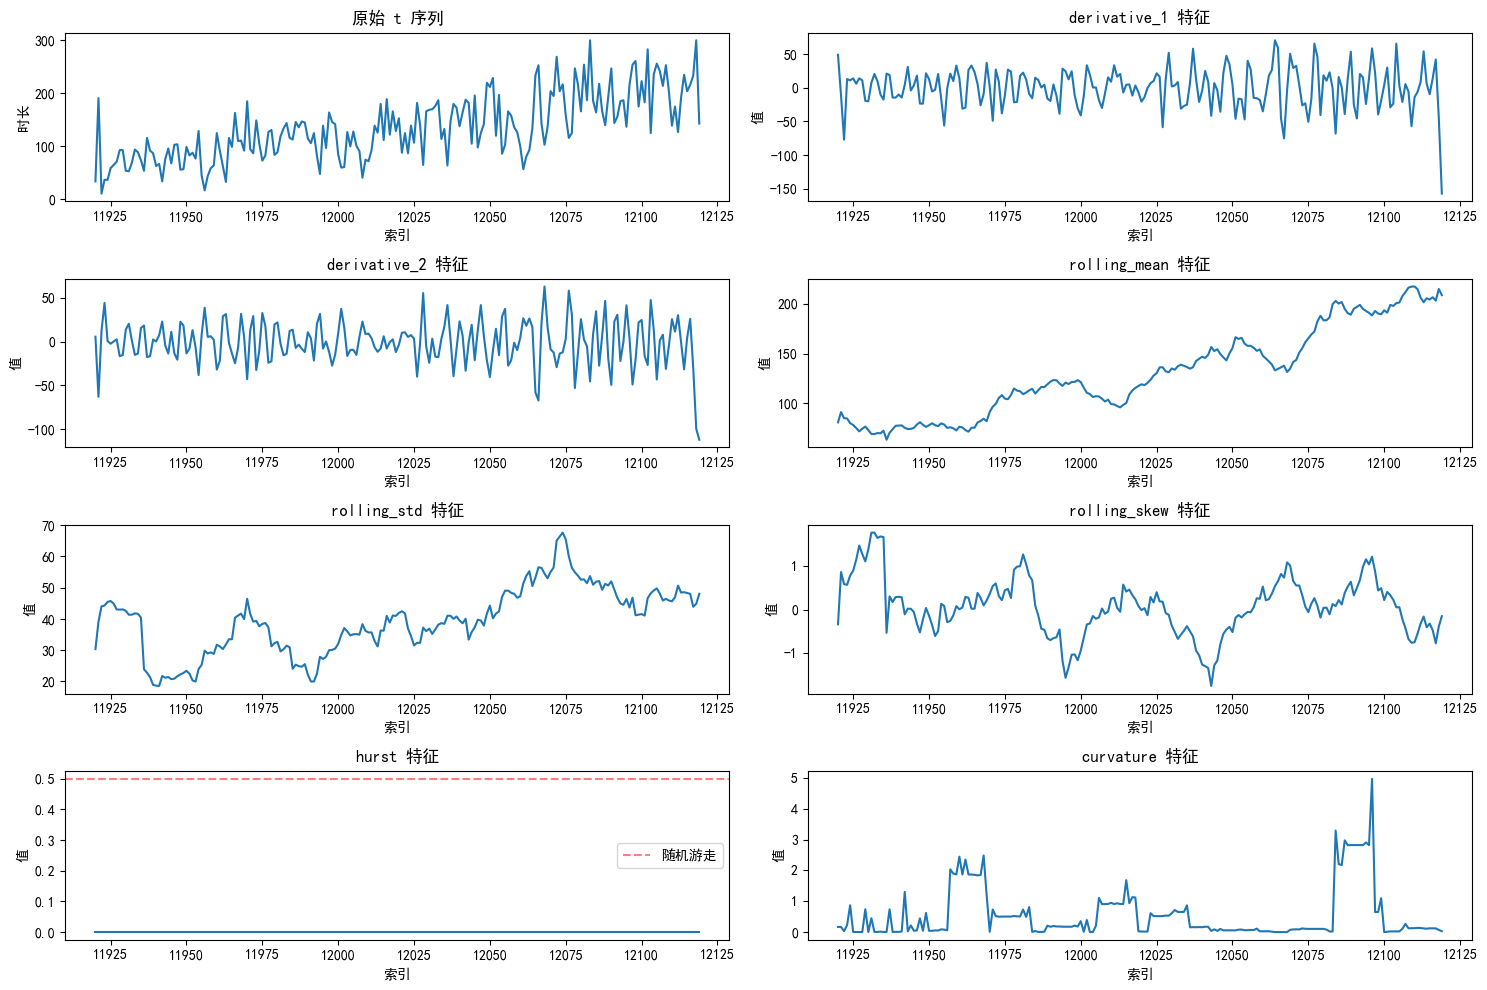

特征已保存到: extracted_features.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False 



class BarFeatureExtractor:

    ### 拓扑和微分特征
    
    def __init__(self, 
                 window_size=20,   #### 默认窗口期，但是以最最下面的窗口期参数为准，不指定的情况下才用默认值
                 calculate_topological=True, 
                 fill_strategy='interpolate',
                 timestamp_col='eob', 
                 duration_col='t'):
    
    ### 初始化特征

        self.window_size = window_size
        self.calculate_topological = calculate_topological
        self.fill_strategy = fill_strategy
        self.timestamp_col = timestamp_col
        self.duration_col = duration_col
        self.features = None
        self.duration_series = None
        
        
        
    def load_data(self, file_path, parse_dates=True, verbose=True):

        ### 加载数据
        df = pd.read_csv(file_path)
        
        ### 解析时间戳
        if parse_dates:
            df[self.timestamp_col] = pd.to_datetime(df[self.timestamp_col])
        
        ### 确保时长列是数值类型
        df[self.duration_col] = pd.to_numeric(df[self.duration_col], errors='coerce')
        
        ### 移除无效行
        df = df.dropna(subset=[self.timestamp_col, self.duration_col])
        
        ### 按时间排序
        df = df.sort_values(self.timestamp_col)
        
        ### 保存时长序列
        self.duration_series = df[self.duration_col]
        
        if verbose:
            print(f"数据加载完成: {len(df)} 行")
            print(f"时间范围: {df[self.timestamp_col].min()} 至 {df[self.timestamp_col].max()}")
            print(f"时长统计: 均值={self.duration_series.mean():.2f}, 标准差={self.duration_series.std():.2f}")
        
        return df
    
    
    
    def extract_features(self, duration_series=None, verbose=True):

        ### 提取几何特征

        ###  使用提供的序列或已加载的序列
        if duration_series is not None:
            self.duration_series = duration_series
        elif self.duration_series is None:
            raise ValueError("请先加载数据或提供时长序列")
        
        ###  确保数据是Series
        if not isinstance(self.duration_series, pd.Series):
            self.duration_series = pd.Series(self.duration_series)
        
        if verbose:
            print(f"\n提取特征: 序列长度={len(self.duration_series)}, 窗口大小={self.window_size}")
        
        ###  创建特征DataFrame
        features = pd.DataFrame({self.duration_col: self.duration_series})
        
        ####  基础微分特征
        features['derivative_1'] = np.gradient(features[self.duration_col])  ###  一阶导数
        features['derivative_2'] = np.gradient(features['derivative_1'])  ###  二阶导数
        
        ### 局部统计特征
        features['rolling_mean'] = features[self.duration_col].rolling(window=self.window_size).mean()
        features['rolling_std'] = features[self.duration_col].rolling(window=self.window_size).std()
        features['rolling_skew'] = features[self.duration_col].rolling(window=self.window_size).skew()
        
        ### 分形特征
        max_lag = 10  ###  减小滞后值降低计算门槛
        hurst_window = max_lag * 3  ###  窗口大小设为滞后值的3倍，确保有足够的数据
        
        
        
        def hurst_exponent(ts):

            ### 计算时间序列的Hurst

            valid_ts = ts.dropna()
            n = len(valid_ts)
            
            ###  数据量至少为滞后值的2倍
            if n < 2 * max_lag:
                return np.nan
            
            ###  计算各滞后的标准差
            lags = range(2, max_lag)
            tau = []
            for lag in lags:
                if lag >= n:  ###  滞后不能超过数据长度
                    continue
                ###  计算滞后差异的标准差
                diff = valid_ts[lag:] - valid_ts[:-lag]
                std_diff = np.std(diff)
                
                ###  处理接近0的情况，避免log(0)错误
                if std_diff < 1e-10:
                    std_diff = 1e-10
                tau.append(std_diff)
            
            ###  至少需要5个有效滞后值
            if len(tau) < 5:
                return np.nan
            
            ###  拟合线性回归
            try:
                log_lags = np.log(list(lags)[:len(tau)])  ###  滞后的对数
                log_tau = np.log(tau)  ###  标准差的对数
                slope, _ = np.polyfit(log_lags, log_tau, 1)  ###  拟合斜率
                hurst = slope * 2.0  # ## 计算Hurst
                
                ###  Hurst值必须在合理范围内（0 < Hurst < 1）
                if 0 < hurst < 1:
                    return hurst
                else:
                    return np.nan
            except:
                ###  捕获所有拟合异常
                return np.nan
        
        ###  滚动窗口计算Hurst
        features['hurst'] = features[self.duration_col].rolling(window=hurst_window).apply(hurst_exponent)
        
        
        
        #### 曲率特征
        
        def local_curvature(ts):
            #### 计算局部曲率
            if len(ts.dropna()) < 3:
                return np.nan
                
            x = np.arange(len(ts))
            y = ts
            dx_dt = np.gradient(x)
            dy_dt = np.gradient(y)
            d2x_dt2 = np.gradient(dx_dt)
            d2y_dt2 = np.gradient(dy_dt)
            
            denominator = (dx_dt**2 + dy_dt**2)**1.5
            denominator[denominator < 1e-10] = np.nan
            
            curvature = np.abs(d2x_dt2 * dy_dt - d2y_dt2 * dx_dt) / denominator
            return np.nanmean(curvature)
        
        features['curvature'] = features[self.duration_col].rolling(window=self.window_size).apply(local_curvature)
        
        #### 持续熵
        if self.calculate_topological:
            def persistence_entropy_giotto(ts):

                valid_ts = ts.dropna()
                if len(valid_ts) < 10:
                    return np.nan
                    
                X = valid_ts.values.reshape(1, -1, 1)
                
                try:
                    VR = VietorisRipsPersistence(homology_dimensions=[0, 1])
                    diagrams = VR.fit_transform(X)
                    entropy = PersistenceEntropy()
                    return entropy.fit_transform(diagrams)[0, 0]
                except Exception as e:
                    if verbose:
                        print(f"拓扑特征计算失败: {e}")
                    return np.nan
            
            features['persistence_entropy'] = features[self.duration_col].rolling(window=self.window_size*2).apply(
                persistence_entropy_giotto
            )
        
        ###  处理缺失值
        if self.fill_strategy == 'interpolate':
            for col in features.columns:

                if col == 'hurst':
                    features[col] = features[col].interpolate(method='linear', limit_direction='forward')
                    features[col] = features[col].fillna(0.5)  ###  缺省值用随机游走的Hurst值0.5
                else:
                    features[col] = features[col].interpolate(method='linear', limit_direction='both')
                    features[col] = features[col].fillna(features[col].mean())
        elif self.fill_strategy == 'mean':
            for col in features.columns:
                if col == 'hurst':
                    features[col] = features[col].fillna(0.5)  ###  特殊处理
                else:
                    features[col] = features[col].fillna(features[col].mean())
        elif self.fill_strategy == 'drop':
            features = features.dropna()
        
        ###  保存特征
        self.features = features
        
        ###  计算缺失值统计
        if verbose:
            print("\n特征缺失值统计:")
            missing_counts = features.isnull().sum()
            for col, count in missing_counts.items():
                if count > 0:
                    print(f"{col}: {count} 个缺失值 ({count/len(features):.2%})")
            
            print(f"\n成功提取特征: {', '.join(features.columns.tolist())}")
        
        return features
    
    
    
    def visualize_features(self, n_samples=None, figsize=(15, 10)):

        if self.features is None:
            raise ValueError("请先提取特征")
        
        ###  选择要可视化的特征
        feature_cols = [col for col in self.features.columns if col != self.duration_col]
        
        ###  确定可视化的数据范围
        plot_data = self.features
        if n_samples is not None and n_samples < len(self.features):
            plot_data = self.features.iloc[-n_samples:]
            print(f"可视化最后 {n_samples} 个样本")
        

        n_features = len(feature_cols)
        n_rows = (n_features + 1) // 2  
        fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
        axes = axes.flatten()
        

        axes[0].plot(plot_data.index, plot_data[self.duration_col])
        axes[0].set_title(f'原始 {self.duration_col} 序列')
        axes[0].set_xlabel('索引')
        axes[0].set_ylabel('时长')
        
        ###  绘制每个特征
        for i, col in enumerate(feature_cols, 1):
            if i < len(axes):
                axes[i].plot(plot_data.index, plot_data[col])
                axes[i].set_title(f'{col} 特征')
                axes[i].set_xlabel('索引')
                axes[i].set_ylabel('值')
                ###  为Hurst指数添加0.5为随机游走的参考线
                if col == 'hurst':
                    axes[i].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='随机游走')
                    axes[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    
    def save_features(self, file_path):
        #### 保存特征
        if self.features is None:
            raise ValueError("请先提取特征")
        
        self.features.to_csv(file_path, index=True)
        print(f"特征已保存到: {file_path}")


        
        

if __name__ == "__main__":

    extractor = BarFeatureExtractor(
        window_size=15,                   ####  滑动窗口大小
        calculate_topological=True,    ####  是否计算拓扑特征
        fill_strategy='interpolate',   ####  缺失值填充策略
        timestamp_col='eob',         ####  时间戳列名
        duration_col='t'        ####  bar时长列名
    )
    
    
    
    #### 处理自定义轴文件中的bar时长为 t 列
    
    df = pd.read_csv('./RB99_1m_Turnover_31000_12120_1213.csv')      ########  自定义轴文件
    df['t'] = df['hang'].diff(1)
    df.to_csv('./test.csv',index = False) 
    
    
    
    
    ### 加载处理后的自定义轴文件
    data = extractor.load_data('./test.csv')
    
    ### 提取特征
    features = extractor.extract_features()
    
   
    ### 可视化最后200个特征
    extractor.visualize_features(n_samples=200)
    
    ### 保存特征
    extractor.save_features('extracted_features.csv')
    